# Predicting Bad Brands
<b>Input Files</b>
- products.csv
- ratings.csv
- network_metrics.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import shap
import seaborn as sns
sns.set_style('whitegrid')
plt.rc('font', size=10) 

import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.model_selection import FeatureImportances
from sklearn.inspection import permutation_importance


/Users/rachelsng/miniforge3/envs/general/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rc('xtick', labelsize=SMALL_SIZE) 
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('figure', titlesize=BIGGER_SIZE)

# 0. Load & Merge Datasets

In [3]:
# Load product dataset
products = pd.read_csv('products.csv',sep = ";", header=None)
products = products.drop(4, axis = 1) # comment this out on your end

products.columns = ['asin', 'title', 'brand', 'main_cat']
products.head()

,asin,title,brand,main_cat
0,0011300000,Genuine Geovision 1 Channel 3rd Party NVR IP S...,GeoVision,Camera & Photo
1,0043396828,Books Handbook of Astronomical Image Processin...,33 Books Co.,Camera & Photo
2,0060009810,One Hot Summer,Visit Amazon's Carolina Garcia Aguilera Page,Books
3,0060219602,Hurray for Hattie Rabbit: Story and pictures (...,Visit Amazon's Dick Gackenbach Page,Books
4,0060786817,sex.lies.murder.fame.: A Novel,Visit Amazon's Lolita Files Page,Books


In [4]:
# Load ratings
ratings = pd.read_csv('ratings.csv',sep = ",", header=None)

ratings.columns = ['item_id', 'user_id', 'rating', 'date']
ratings.head()

,item_id,user_id,rating,date
0,0060009810,A1N070NS9CJQ2I,5.0,2002-07-17
1,0060009810,A3P0KRKOBQK1KN,5.0,2002-07-06
2,0060009810,A192HO2ICJ75VU,5.0,2002-07-03
3,0060009810,A2T278FKFL3BLT,4.0,2002-06-30
4,0060009810,A2ZUXVTW8RXBXW,5.0,2002-06-28


'item_id' and 'asin' both represent product codes. Let's merge the two dataframes.

In [5]:
df = pd.merge(products, ratings, how='inner', left_on='asin', right_on='item_id')
df.head()

,asin,title,brand,main_cat,item_id,user_id,rating,date
0,0011300000,Genuine Geovision 1 Channel 3rd Party NVR IP S...,GeoVision,Camera & Photo,0011300000,A1T5YS00MO2Y6T,2.0,2016-12-03
1,0011300000,Genuine Geovision 1 Channel 3rd Party NVR IP S...,GeoVision,Camera & Photo,0011300000,A3W3PYCK3TFWMX,3.0,2015-03-19
2,0043396828,Books Handbook of Astronomical Image Processin...,33 Books Co.,Camera & Photo,0043396828,A1HABHUYW9J95Q,3.0,2018-01-14
3,0060009810,One Hot Summer,Visit Amazon's Carolina Garcia Aguilera Page,Books,0060009810,A1N070NS9CJQ2I,5.0,2002-07-17
4,0060009810,One Hot Summer,Visit Amazon's Carolina Garcia Aguilera Page,Books,0060009810,A3P0KRKOBQK1KN,5.0,2002-07-06


Create the dataframe with brands as observations.

In [6]:
brands = pd.read_csv('network_metrics.csv',sep = ",")[['Brand', 'bad_brand']]
brands.drop_duplicates(inplace=True)
brands.reset_index(inplace=True)
brands.drop('index', axis=1, inplace=True)
brands.rename(columns={'Brand':'brand', 'bad_brand':'banned'}, inplace=True)
brands

,brand,banned
0,Amzdeal,1
1,AUKEY,1
2,CHOETECH,1
3,HooToo,1
4,LETSCOM,1
...,...,...
120,VIVO,0
121,WEme,0
122,Yamaha Audio,0
123,YETOR,0


In [7]:
brands['banned'].value_counts()

0    111
1     14
Name: banned, dtype: int64

111 good brands, 14 bad brands

'labelled_df' is filtered from the original df to only contain the good or bad brands we have sampled.

In [8]:
# Restrict brands
labelled_df = df[df['brand'].isin(brands['brand'])]
labelled_df.head()

,asin,title,brand,main_cat,item_id,user_id,rating,date
5715,1060641194,Professional Kingston Ultra 64GB MicroSDXC for...,Kingston,Computers,1060641194,A20JTOU8SLNW1X,4.0,2015-05-21
5919,1060664895,Professional Kingston Ultra 64GB MicroSDXC for...,Kingston,Computers,1060664895,AQU60DU87DWNU,1.0,2014-10-05
5972,1060646757,Professional Kingston Ultra 64GB MicroSDXC for...,Kingston,Computers,1060646757,A1EIWDT6KFJ3QS,5.0,2015-03-13
5977,1061512711,Professional Kingston 32GB MicroSDHC Card for ...,Kingston,Computers,1061512711,AKBM16N296T1U,5.0,2015-11-05
6871,106246284X,Professional Kingston 8GB MicroSDHC Card for G...,Kingston,Computers,106246284X,AP34TY6L8VGMM,1.0,2014-11-19


# 1. Feature Engineering

In [9]:
# Count number of main categories by brand
df3 = labelled_df.groupby('brand', as_index=False)['main_cat'].nunique()
df3.rename(columns={'main_cat': 'n_categories'}, inplace=True)
brands_1 = pd.merge(brands, df3, how='inner', left_on=['brand'], right_on=['brand'])
brands_1.head()

,brand,banned,n_categories
0,Amzdeal,1,6
1,AUKEY,1,6
2,CHOETECH,1,2
3,HooToo,1,7
4,LETSCOM,1,1


In [10]:
# Count the number of customers for the brand
df4 = pd.DataFrame(labelled_df.groupby('brand', as_index=False)['user_id'].nunique())
df4.rename(columns={'user_id': 'customer_count'}, inplace=True)
brands_2 = pd.merge(brands_1, df4, how='inner', left_on=['brand'], right_on=['brand'])
brands_2.head()

,brand,banned,n_categories,customer_count
0,Amzdeal,1,6,306
1,AUKEY,1,6,11682
2,CHOETECH,1,2,814
3,HooToo,1,7,9925
4,LETSCOM,1,1,244


In [11]:
# Count the number of transactions recorded for the brand
df4 = pd.DataFrame(labelled_df.groupby('brand', as_index=False)['user_id'].count())
df4.rename(columns={'user_id': 'transaction_count'}, inplace=True)
brands_2 = pd.merge(brands_2, df4, how='inner', left_on=['brand'], right_on=['brand'])
brands_2.head()

,brand,banned,n_categories,customer_count,transaction_count
0,Amzdeal,1,6,306,310
1,AUKEY,1,6,11682,12132
2,CHOETECH,1,2,814,818
3,HooToo,1,7,9925,10300
4,LETSCOM,1,1,244,244


In [12]:
# Count the number of items for the brand
df4 = pd.DataFrame(labelled_df.groupby('brand', as_index=False)['item_id'].nunique())
df4.rename(columns={'item_id': 'item_count'}, inplace=True)
brands_2 = pd.merge(brands_2, df4, how='inner', left_on=['brand'], right_on=['brand'])
brands_2.head()

,brand,banned,n_categories,customer_count,transaction_count,item_count
0,Amzdeal,1,6,306,310,15
1,AUKEY,1,6,11682,12132,69
2,CHOETECH,1,2,814,818,8
3,HooToo,1,7,9925,10300,48
4,LETSCOM,1,1,244,244,3


In [13]:
# Compute the average rating of the brand
df5 = pd.DataFrame(labelled_df.groupby('brand', as_index=False)['rating'].mean())
df5.rename(columns={'rating': 'avg_rating'}, inplace=True)
brands_3 = pd.merge(brands_2, df5, how='inner', left_on=['brand'], right_on=['brand'])
brands_3.head()

,brand,banned,n_categories,customer_count,transaction_count,item_count,avg_rating
0,Amzdeal,1,6,306,310,15,4.100000
1,AUKEY,1,6,11682,12132,69,4.168150
2,CHOETECH,1,2,814,818,8,4.266504
3,HooToo,1,7,9925,10300,48,4.160583
4,LETSCOM,1,1,244,244,3,4.610656


In [14]:
# Compute the standard deviation of the rating of the brand
df6 = pd.DataFrame(labelled_df.groupby('brand', as_index=False)['rating'].std())
df6.rename(columns={'rating': 'std_rating'}, inplace=True)
brands_4 = pd.merge(brands_3, df6, how='inner', left_on=['brand'], right_on=['brand'])
brands_4.head()

,brand,banned,n_categories,customer_count,transaction_count,item_count,avg_rating,std_rating
0,Amzdeal,1,6,306,310,15,4.100000,1.304585
1,AUKEY,1,6,11682,12132,69,4.168150,1.306312
2,CHOETECH,1,2,814,818,8,4.266504,1.361250
3,HooToo,1,7,9925,10300,48,4.160583,1.338242
4,LETSCOM,1,1,244,244,3,4.610656,0.874919


In [15]:
# Compute the average length of the titles of the brand's products
labelled_df['len_title'] = labelled_df['title'].apply(lambda x: len(x))
df7 = pd.DataFrame(labelled_df.groupby('brand', as_index=False)['len_title'].mean())
df7.rename(columns={'len_title': 'avg_title_length'}, inplace=True)
brands_5 = pd.merge(brands_4, df7, how='inner', left_on=['brand'], right_on=['brand'])
brands_5.head()

,brand,banned,n_categories,customer_count,transaction_count,item_count,avg_rating,std_rating,avg_title_length
0,Amzdeal,1,6,306,310,15,4.100000,1.304585,103.106452
1,AUKEY,1,6,11682,12132,69,4.168150,1.306312,149.587702
2,CHOETECH,1,2,814,818,8,4.266504,1.361250,191.695599
3,HooToo,1,7,9925,10300,48,4.160583,1.338242,153.215922
4,LETSCOM,1,1,244,244,3,4.610656,0.874919,60.135246


In [16]:
# Keep the predominant category
df8 = pd.DataFrame(labelled_df.groupby('brand', as_index=False)['main_cat'].agg(pd.Series.mode))
df8.rename(columns={'main_cat': 'most_freq_cat'}, inplace=True)
brands_6 = pd.merge(brands_5, df8, how='inner', left_on=['brand'], right_on=['brand'])
brands_6.head()

,brand,banned,n_categories,customer_count,transaction_count,item_count,avg_rating,std_rating,avg_title_length,most_freq_cat
0,Amzdeal,1,6,306,310,15,4.100000,1.304585,103.106452,Computers
1,AUKEY,1,6,11682,12132,69,4.168150,1.306312,149.587702,Computers
2,CHOETECH,1,2,814,818,8,4.266504,1.361250,191.695599,Computers
3,HooToo,1,7,9925,10300,48,4.160583,1.338242,153.215922,Computers
4,LETSCOM,1,1,244,244,3,4.610656,0.874919,60.135246,Computers


In [17]:
# OHE most_freq_cat
final_brands = pd.get_dummies(brands_6, columns=['most_freq_cat'])
final_brands.head()

,brand,banned,n_categories,customer_count,transaction_count,item_count,avg_rating,std_rating,avg_title_length,most_freq_cat_All Electronics,most_freq_cat_Amazon Home,most_freq_cat_Automotive,most_freq_cat_Camera & Photo,most_freq_cat_Car Electronics,most_freq_cat_Cell Phones & Accessories,most_freq_cat_Computers,most_freq_cat_Home Audio & Theater,most_freq_cat_Office Products,most_freq_cat_Sports & Outdoors,most_freq_cat_Tools & Home Improvement
0,Amzdeal,1,6,306,310,15,4.100000,1.304585,103.106452,0,0,0,0,0,0,1,0,0,0,0
1,AUKEY,1,6,11682,12132,69,4.168150,1.306312,149.587702,0,0,0,0,0,0,1,0,0,0,0
2,CHOETECH,1,2,814,818,8,4.266504,1.361250,191.695599,0,0,0,0,0,0,1,0,0,0,0
3,HooToo,1,7,9925,10300,48,4.160583,1.338242,153.215922,0,0,0,0,0,0,1,0,0,0,0
4,LETSCOM,1,1,244,244,3,4.610656,0.874919,60.135246,0,0,0,0,0,0,1,0,0,0,0


# 2. Run Baseline ML Model

In [18]:
# Shuffle final_brands
final_brands = final_brands.sample(len(final_brands), random_state=5104) # set random seed for reproducibility

good_final_brands = final_brands[final_brands['banned']==0]
bad_final_brands = final_brands[final_brands['banned']==1]
print(len(good_final_brands)*0.70)
print(len(bad_final_brands)*0.70)

77.69999999999999
9.799999999999999


In [19]:
# Check bad brands in train and test set
train_set_baseline = pd.concat([good_final_brands.iloc[:78,:], bad_final_brands.iloc[:10,:]], axis=0)
print('Bad brands in train set: {}'.format(train_set_baseline['brand'][train_set_baseline['banned']==1].tolist()))
test_set_baseline = pd.concat([good_final_brands.iloc[78:,:], bad_final_brands.iloc[10:,:]], axis=0)
print('Bad brands in test set: {}'.format(test_set_baseline['brand'][test_set_baseline['banned']==1].tolist()))

Bad brands in train set: ['TOMTOP', 'CHOETECH', 'VicTsing', 'Vtin', 'OMORC', 'Amzdeal', 'Mpow', 'YKS', 'TaoTronics', 'AUKEY']
Bad brands in test set: ['RAVPower', 'VOGEK', 'HooToo', 'LETSCOM']


In [20]:
X_train_baseline = train_set_baseline.drop(['banned', 'brand'], axis=1)
y_train_baseline = train_set_baseline['banned']

X_test_baseline = test_set_baseline.drop(['banned', 'brand'], axis=1)
y_test_baseline = test_set_baseline['banned']

In [21]:
# Double check features
X_train_baseline.columns

Index(['n_categories', 'customer_count', 'transaction_count', 'item_count',
       'avg_rating', 'std_rating', 'avg_title_length',
       'most_freq_cat_All Electronics', 'most_freq_cat_Amazon Home',
       'most_freq_cat_Automotive', 'most_freq_cat_Camera & Photo',
       'most_freq_cat_Car Electronics',
       'most_freq_cat_Cell Phones & Accessories', 'most_freq_cat_Computers',
       'most_freq_cat_Home Audio & Theater', 'most_freq_cat_Office Products',
       'most_freq_cat_Sports & Outdoors',
       'most_freq_cat_Tools & Home Improvement'],
      dtype='object')

In [22]:
print('Number of banned brands in training set:',y_train_baseline.sum())
print('Number of banned brands in testing set:',y_test_baseline.sum())

Number of banned brands in training set: 10
Number of banned brands in testing set: 4


In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, plot_confusion_matrix, plot_roc_curve

def performance_report(model, X_test, y_test):
    y_predict = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    print(classification_report(y_test,y_predict))
    #print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
    
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.rc('font', size=30) 
    plot_confusion_matrix(model, X_test, y_test, ax=ax)  
    plt.grid(False)
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print('AUC:', roc_auc)
    plot_roc_curve(model, X_test, y_test)  
    plt.show()

## 2.1 XGBoost Tuning and Prediction

In [24]:
# # XGB Model
# xgb_baseline = XGBClassifier(
#     seed=42,
#     learning_rate=0.01,
#     n_estimators=500,
#     gamma=0.1,
#     eval_metric = 'logloss'
# )

# param_grid = {
#     'max_depth': [6,7,8],
#     'min_child_weight': [1,2],
#     'colsample_bytree': [0.5, 0.6],
#     'scale_pos_weight': [10, 11, 12]
# }

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# CV_xgb_baseline = GridSearchCV(estimator=xgb_baseline, param_grid=param_grid, cv= cv, scoring='roc_auc')
# CV_xgb_baseline.fit(X_train_baseline, y_train_baseline)

# print(CV_xgb_baseline.best_params_)

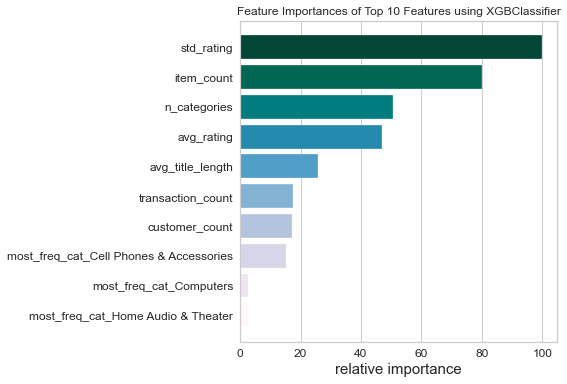

<AxesSubplot:title={'center':'Feature Importances of Top 10 Features using XGBClassifier'}, xlabel='relative importance'>

In [25]:
#{'colsample_bytree': 0.6, 'max_depth': 7, 'min_child_weight': 2, 'scale_pos_weight': 11}

xgb_baseline = XGBClassifier(
    random_state=42,
    learning_rate=0.01,
    n_estimators=500,
    gamma=0.1,
    scale_pos_weight=11,
    max_depth=7,
    min_child_weight=2,
    colsample_bytree=0.6,
    importance_type = 'total_gain',
    eval_metric = 'logloss'
)

xgb_baseline.fit(X_train_baseline,y_train_baseline)

model = xgb_baseline
viz = FeatureImportances(model, topn=10, colormap='PuBuGn')
viz.fit(X_test_baseline, y_test_baseline)
viz.show()

              precision    recall  f1-score   support

           0       0.91      0.94      0.93        33
           1       0.33      0.25      0.29         4

    accuracy                           0.86        37
   macro avg       0.62      0.59      0.61        37
weighted avg       0.85      0.86      0.86        37



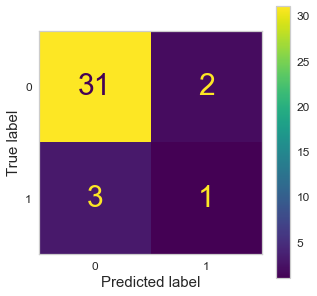

AUC: 0.6666666666666666


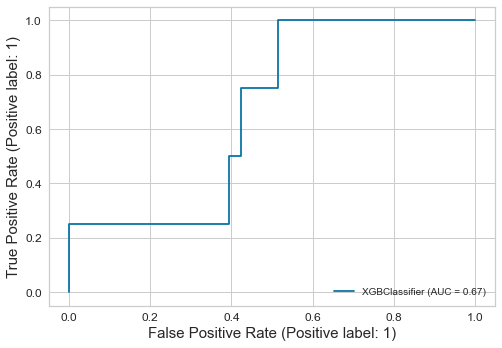

In [26]:
performance_report(xgb_baseline, X_test_baseline, y_test_baseline)

# 3. Add Network Metrics

In [27]:
network_metrics = pd.read_csv('network_metrics.csv', index_col='Unnamed: 0')
network_metrics.rename(columns={'bad_brand': 'banned', 'Brand':'brand'}, inplace=True)
network_metrics = network_metrics[network_metrics['year']==2017] # take only metrics from 2017
network_metrics.drop(['year', 'banned'], axis=1, inplace=True)
network_metrics.head()

,brand,density,degree,diameter,clustering,largest_component,n_nodes,n_edges
2,Amzdeal,0.148649,5.351351,6.0,0.767442,10.0,37,99
5,AUKEY,0.013990,79.838472,25.0,0.756120,201.0,5708,227859
8,CHOETECH,0.105933,56.356473,8.0,0.760754,109.0,533,15019
11,HooToo,0.047906,161.156018,15.0,0.755059,306.0,3365,271145
14,LETSCOM,0.341667,5.125000,1.0,1.000000,9.0,16,41


In [28]:
final_df = pd.merge(final_brands, network_metrics, how='inner', left_on='brand', right_on='brand')
final_df

,brand,banned,n_categories,customer_count,transaction_count,item_count,avg_rating,std_rating,avg_title_length,most_freq_cat_All Electronics,...,most_freq_cat_Office Products,most_freq_cat_Sports & Outdoors,most_freq_cat_Tools & Home Improvement,density,degree,diameter,clustering,largest_component,n_nodes,n_edges
0,CHUWI,0,1,579,597,21,3.509213,1.590238,126.546064,0,...,0,0,0,0.054407,9.956522,6.0,0.706617,16.0,184,916
1,EnGenius,0,5,2102,2289,122,3.989952,1.446416,87.533421,0,...,0,0,0,0.017751,6.035191,12.0,0.761707,17.0,341,1029
2,Skullcandy,0,11,37505,39408,636,3.815012,1.478974,91.024640,0,...,0,0,0,0.010104,81.798691,22.0,0.744968,183.0,8097,331162
3,Braven,0,4,2833,2896,58,4.137776,1.318138,108.257251,0,...,0,0,0,0.017594,9.535912,7.0,0.679232,21.0,543,2589
4,TOMTOP,1,12,1404,1425,52,3.831579,1.475354,97.819649,1,...,0,0,0,0.053144,9.672131,9.0,0.783912,19.0,183,885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,HooToo,1,7,9925,10300,48,4.160583,1.338242,153.215922,0,...,0,0,0,0.047906,161.156018,15.0,0.755059,306.0,3365,271145
121,RND,0,1,2239,2269,14,4.077567,1.374104,149.117673,0,...,0,0,0,0.062621,8.015504,7.0,0.873274,20.0,129,517
122,GW Security Inc,0,5,3917,4249,425,4.217463,1.316191,145.250647,0,...,0,0,0,0.093428,90.064249,12.0,0.723994,140.0,965,43456
123,ORICO,0,5,8096,8319,226,4.148576,1.346469,127.867893,0,...,0,0,0,0.023717,64.461935,15.0,0.751503,159.0,2719,87636


In [29]:
# Create normalised largest component
final_df['largest_comp_norm'] = final_df['largest_component']/final_df['n_nodes']
final_df.columns

Index(['brand', 'banned', 'n_categories', 'customer_count',
       'transaction_count', 'item_count', 'avg_rating', 'std_rating',
       'avg_title_length', 'most_freq_cat_All Electronics',
       'most_freq_cat_Amazon Home', 'most_freq_cat_Automotive',
       'most_freq_cat_Camera & Photo', 'most_freq_cat_Car Electronics',
       'most_freq_cat_Cell Phones & Accessories', 'most_freq_cat_Computers',
       'most_freq_cat_Home Audio & Theater', 'most_freq_cat_Office Products',
       'most_freq_cat_Sports & Outdoors',
       'most_freq_cat_Tools & Home Improvement', 'density', 'degree',
       'diameter', 'clustering', 'largest_component', 'n_nodes', 'n_edges',
       'largest_comp_norm'],
      dtype='object')

# 4. ML models with network metrics

In [30]:
# Use original train_test split to split new metrics
train_set = final_df[final_df['brand'].isin(train_set_baseline['brand'].tolist())]
print('Length of train_set: {}'.format(len(train_set)))
print('Bad brands in train set: {}'.format(train_set['brand'][train_set['banned']==1].tolist()))

test_set = final_df[final_df['brand'].isin(test_set_baseline['brand'].tolist())]
print('Length of train_set: {}'.format(len(test_set)))
print('Bad brands in test set: {}'.format(test_set['brand'][test_set['banned']==1].tolist()))

Length of train_set: 88
Bad brands in train set: ['TOMTOP', 'CHOETECH', 'VicTsing', 'Vtin', 'OMORC', 'Amzdeal', 'Mpow', 'YKS', 'TaoTronics', 'AUKEY']
Length of train_set: 37
Bad brands in test set: ['RAVPower', 'VOGEK', 'HooToo', 'LETSCOM']


In [31]:
X_train = train_set.drop(['banned', 'brand'], axis=1)
y_train = train_set['banned']

X_test = test_set.drop(['banned', 'brand'], axis=1)
y_test = test_set['banned']

## 4.1 XGBoost Tuning and Prediction

In [32]:
# xgb = XGBClassifier(
#     seed=0,
#     colsample_bytree=0.3,
#     gamma=10,
#     learning_rate=0.01,
#     max_depth=6,
#     min_child_weight=2,
#     n_estimators=200,
#     scale_pos_weight=11
# )

# param_grid = {
#     'learning_rate':[0.01],
#     'n_estimators':[200, 300, 400],
#     'max_depth': [6, 7],
#     'min_child_weight': [1,2],
#     'colsample_bytree': [0.4, 0.5, 0.6],
#     'scale_pos_weight': [10, 11],
#     'gamma':[10]
# }

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# CV_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv= cv, scoring='recall')
# CV_xgb.fit(X_train, y_train)

# print(CV_xgb.best_params_)

In [33]:
xgb = XGBClassifier(
    random_state =42,
    colsample_bytree=0.3,
    gamma=10,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=1, 
    n_estimators=300,
    scale_pos_weight=13,
    importance_type = 'total_gain',
    eval_metric = 'logloss'
)

xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, eval_metric='logloss', gamma=10,
              gpu_id=-1, importance_type='total_gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=13, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

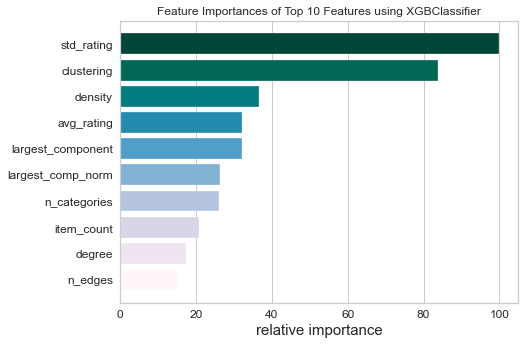

<AxesSubplot:title={'center':'Feature Importances of Top 10 Features using XGBClassifier'}, xlabel='relative importance'>

In [34]:
from yellowbrick.model_selection import FeatureImportances
model = xgb
viz = FeatureImportances(model, topn=10, colormap='PuBuGn')
viz.fit(X_test, y_test)
viz.show()

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        33
           1       0.50      0.75      0.60         4

    accuracy                           0.89        37
   macro avg       0.73      0.83      0.77        37
weighted avg       0.92      0.89      0.90        37



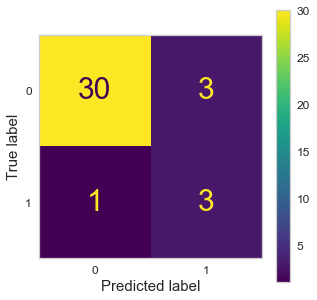

AUC: 0.8939393939393938


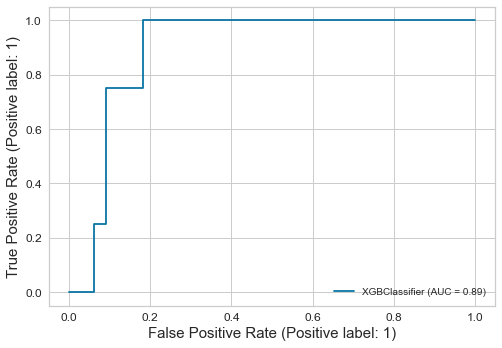

In [35]:
performance_report(xgb, X_test, y_test)

# 5. Further Explanability

## 5.1 ROC-AUC Curves

<Figure size 576x396 with 0 Axes>

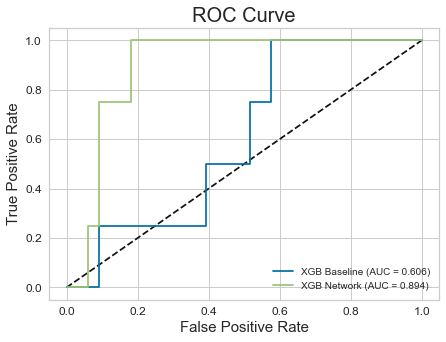

In [36]:
# Combined AUC curves (XGBoost)
dict_classifiers = {
    "XGB Baseline": xgb_baseline,
    "XGB Network": xgb
}

plt.clf()

fig, ax = plt.subplots(figsize=[7,5])
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

lines = []

for i, (model, model_instantiation) in enumerate(dict_classifiers.items()):
    # Compute predicted probabilities: y_pred_prob
    if model == "XGB Baseline":
        y_pred_prob = model_instantiation.predict_proba(X_test_baseline)[:,1]
    
    else:
        y_pred_prob = model_instantiation.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    # plt.plot(fpr, tpr)
    lines += plt.plot(fpr,tpr, label="{} (AUC = {})".format(model, round(roc_auc,3)))

# Create manual labelling
labels = [l.get_label() for l in lines]
plt.legend(lines, labels)
plt.show()

## 5.2 Distribution Differences

In [37]:
good_final_df = final_df[final_df['banned']==0]
bad_final_df = final_df[final_df['banned']==1]

In [38]:
# Summary Statistics (Good)
good_final_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
banned,111.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
n_categories,111.0,5.144144,3.294201,1.000000,3.000000,4.000000,6.000000,1.900000e+01
customer_count,111.0,8228.981982,17710.483846,338.000000,1170.000000,2039.000000,6823.000000,1.328680e+05
transaction_count,111.0,8796.531532,19477.106716,340.000000,1181.500000,2117.000000,6904.500000,1.478840e+05
item_count,111.0,211.369369,479.367726,6.000000,20.500000,47.000000,181.000000,3.050000e+03
avg_rating,111.0,4.051864,0.393521,2.961715,3.806611,4.178108,4.352822,4.667747e+00
std_rating,111.0,1.332781,0.213862,0.851313,1.174477,1.316191,1.525302,1.709638e+00
avg_title_length,111.0,113.914341,41.421633,29.608382,79.690458,111.739080,147.819082,1.966755e+02
most_freq_cat_All Electronics,111.0,0.099099,0.300150,0.000000,0.000000,0.000000,0.000000,1.000000e+00
most_freq_cat_Amazon Home,111.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


In [39]:
# Summary Statistics (Bad)
bad_final_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
banned,14.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
n_categories,14.0,5.857143,3.416186,1.000000,2.250000,6.000000,8.000000,1.200000e+01
customer_count,14.0,9103.642857,12722.985194,179.000000,713.500000,2185.500000,11242.750000,3.544400e+04
transaction_count,14.0,9584.857143,13395.192587,179.000000,714.500000,2208.500000,11674.000000,3.759200e+04
item_count,14.0,41.428571,39.748661,2.000000,13.500000,27.000000,52.750000,1.440000e+02
avg_rating,14.0,4.192241,0.187809,3.831579,4.092475,4.164366,4.264423,4.610656e+00
std_rating,14.0,1.292262,0.145866,0.874919,1.282763,1.331197,1.359983,1.475354e+00
avg_title_length,14.0,133.393045,37.730077,60.135246,105.205574,144.262520,157.619779,1.916956e+02
most_freq_cat_All Electronics,14.0,0.071429,0.267261,0.000000,0.000000,0.000000,0.000000,1.000000e+00
most_freq_cat_Amazon Home,14.0,0.071429,0.267261,0.000000,0.000000,0.000000,0.000000,1.000000e+00


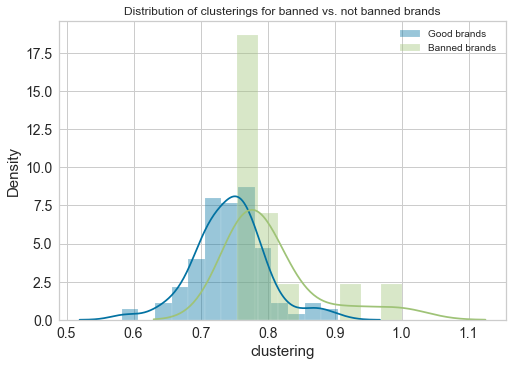

In [52]:
sns.distplot(good_final_df['clustering'], label='Good brands')
sns.distplot(bad_final_df['clustering'], label='Banned brands')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.title('Distribution of clusterings for banned vs. not banned brands')
plt.show()

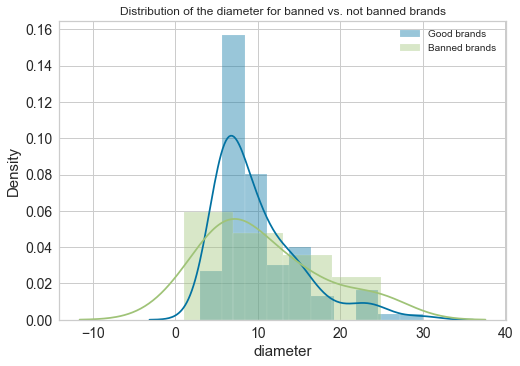

In [51]:
# Plot diameter for banned vs. not banned
sns.distplot(good_final_df['diameter'], label='Good brands')
sns.distplot(bad_final_df['diameter'], label='Banned brands')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.title('Distribution of the diameter for banned vs. not banned brands')
plt.show()

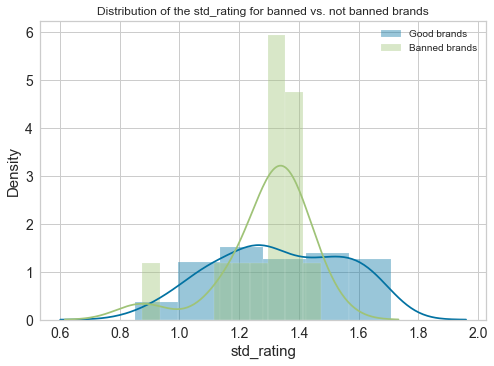

In [53]:
# Plot std_rating for banned vs. not banned
sns.distplot(good_final_df['std_rating'], label='Good brands')
sns.distplot(bad_final_df['std_rating'], label='Banned brands')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.title('Distribution of the std_rating for banned vs. not banned brands')
plt.show()

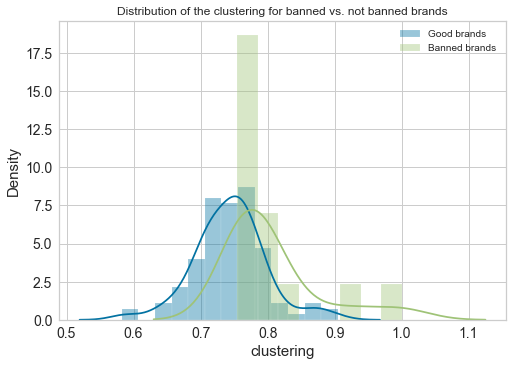

In [54]:
# Plot clustering for banned vs. not banned
sns.distplot(good_final_df['clustering'], label='Good brands')
sns.distplot(bad_final_df['clustering'], label='Banned brands')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.title('Distribution of the clustering for banned vs. not banned brands')
plt.show()

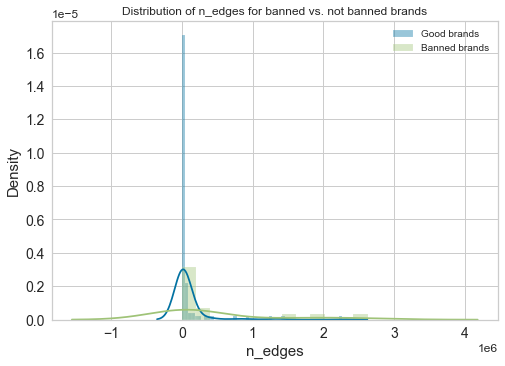

In [56]:
# Plot n_edges for banned vs. not banned
sns.distplot(good_final_df['n_edges'], label='Good brands')
sns.distplot(bad_final_df['n_edges'], label='Banned brands')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.title('Distribution of n_edges for banned vs. not banned brands')
plt.show()

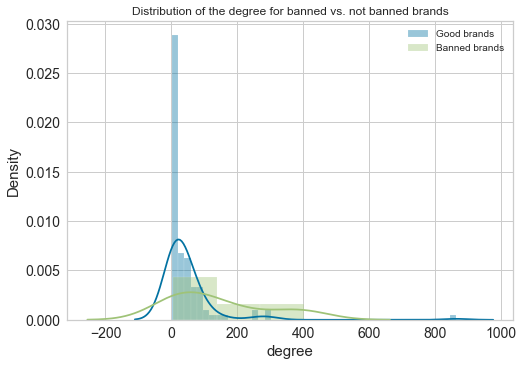

In [57]:
# Plot degree for banned vs. not banned
sns.distplot(good_final_df['degree'], label='Good brands')
sns.distplot(bad_final_df['degree'], label='Banned brands')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.title('Distribution of the degree for banned vs. not banned brands')
plt.show()

## 5.3 Feature Importances

### 5.3.1 Feature Importance (with network)

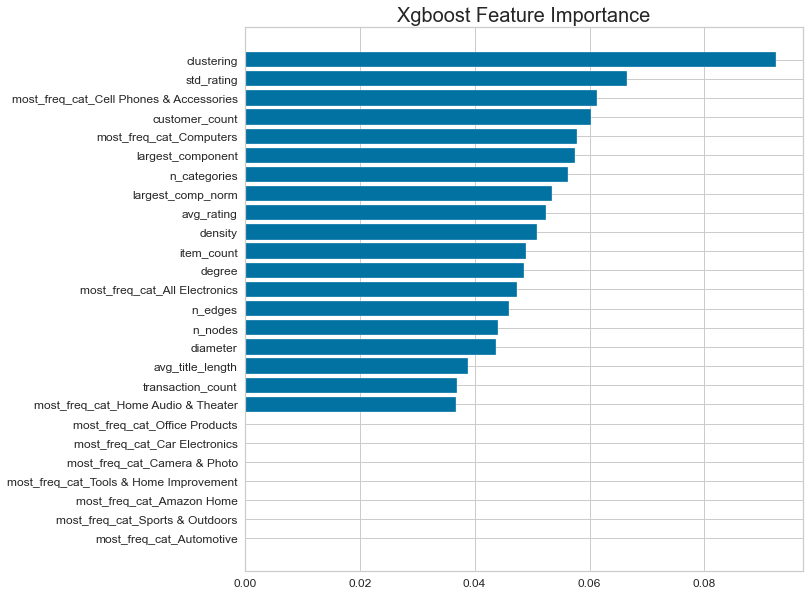

In [58]:
################## XGBoost built-in feature importance
# Set importance type to gain
# The gain type shows the average gain across all splits where feature was used.
xgb.importance_type='gain'

sorted_idx = xgb.feature_importances_.argsort()
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(X_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.rc('ytick', labelsize=10)
plt.title("Xgboost Feature Importance", fontsize=20)
plt.show()

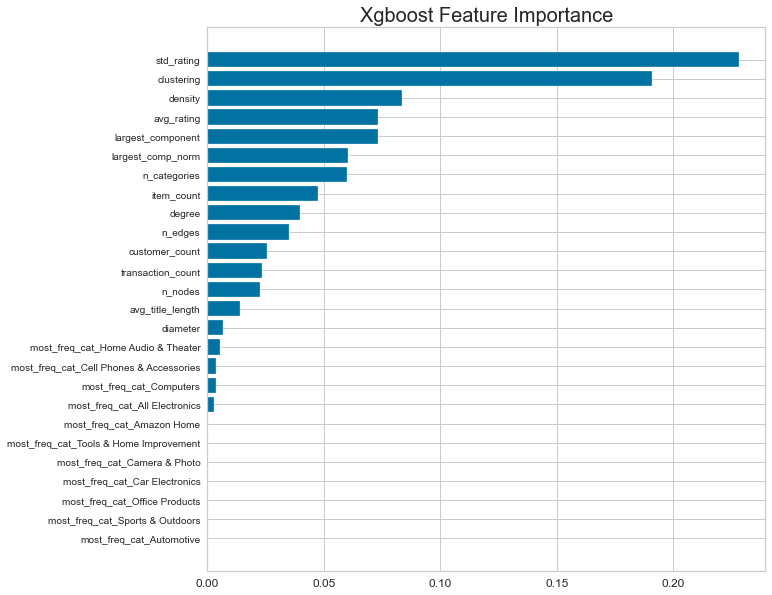

In [59]:
xgb.importance_type = 'total_gain'

sorted_idx = xgb.feature_importances_.argsort()
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(X_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.rc('ytick', labelsize=20)
plt.title("Xgboost Feature Importance", fontsize=20)
plt.show()

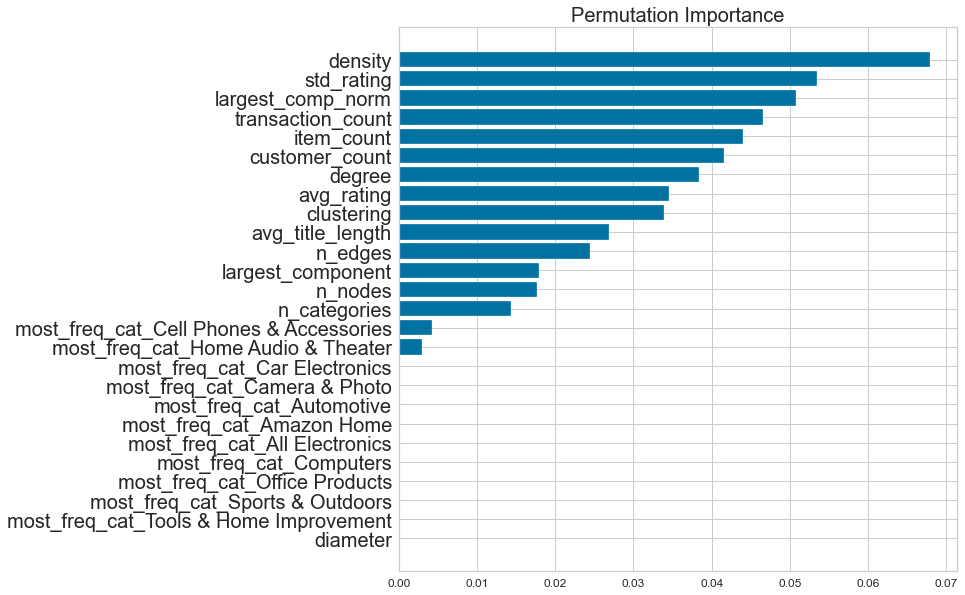

In [60]:
perm_importance = permutation_importance(xgb, X_test, y_test, n_repeats = 200, random_state = 42)

sorted_idx = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10,10))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.rc('ytick', labelsize=10)
plt.title("Permutation Importance", fontsize=20)
plt.show()

### 5.3.2 Feature Importance (without network)

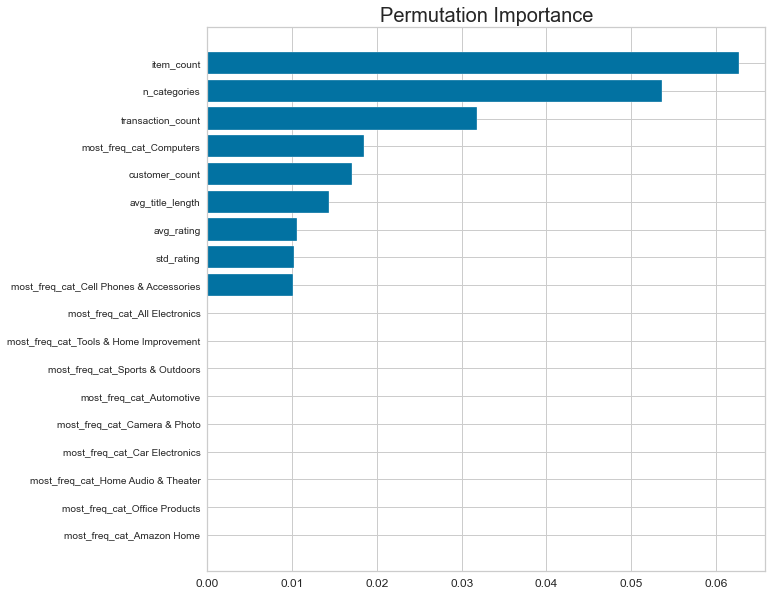

In [61]:
############## Permutation based feature importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(xgb_baseline, X_test_baseline, y_test_baseline, n_repeats = 200, random_state = 42)

sorted_idx = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10,10))
plt.barh(X_test_baseline.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.rc('ytick', labelsize=10)
plt.title("Permutation Importance", fontsize=20)
plt.show()

## 5.4 SHAP

In [69]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

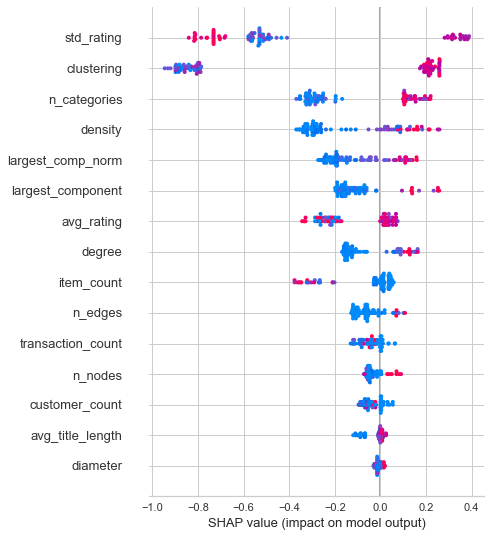

In [86]:
shap.summary_plot(shap_values, X_train, max_display = 15, plot_size=[6,9], color_bar = False)
plt.show()